# Reading and Writing Data into TFRecords
### By Jason Wei

I downloaded the MNIST dataset straight in png format from [here](https://github.com/myleott/mnist_png).

Writing MNIST data into TFrecords, and reading it back in again.

This code modifies this [blog post](http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html) on dogs and cats.

In [1]:
from random import shuffle
import glob
import cv2
import tensorflow as tf
import numpy as np
import sys

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Read in the classes and their labels. Shuffle them. 

In [2]:
all_addresses = []
all_labels = []

mnist_path = 'mnist_png/training/'
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for c in classes:
    c = str(c)
    mnist_class_path = 'mnist_png/training/' + c + '/*' 
    pic_addresses = glob.glob(mnist_class_path)
    all_addresses += pic_addresses
    for i in range(len(pic_addresses)): #
        all_labels.append(c)
    print(mnist_class_path, len(pic_addresses))

#shuffle the data
c = list(zip(all_addresses, all_labels))
shuffle(c)
addrs, labels = zip(*c)

mnist_png/training/0/* 5923
mnist_png/training/1/* 6742
mnist_png/training/2/* 5958
mnist_png/training/3/* 6131
mnist_png/training/4/* 5842
mnist_png/training/5/* 5421
mnist_png/training/6/* 5918
mnist_png/training/7/* 6265
mnist_png/training/8/* 5851
mnist_png/training/9/* 5949


Separate into training, validation, and test labels. 

In [3]:
train_addrs = addrs[0:int(0.6 * len(addrs))]
train_labels = labels[0:int(0.6 * len(labels))]
val_addrs = addrs[int(0.6 * len(addrs)):int(0.8 * len(addrs))]
val_labels = labels[int(0.6 * len(addrs)):int(0.8 * len(addrs))]
test_addrs = addrs[int(0.8 * len(addrs)):]
test_labels = labels[int(0.8 * len(labels)):]

def load_image(addr): #resize it to 28 by 28. 
    img = cv2.imread(addr)
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img#[:, :, 0] #we don't want three color channels since it is in black and white so they are all the same.

Write data into TFRecords file.

In [7]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

train_filename = 'train.tfrecords'  # address to save the TFRecords file
# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)
for i in range(len(train_addrs)):
    # print how many images are saved every 6000 images
    if not i % 6000:
        print('Train data: {}/{}'.format(i, len(train_addrs)))
        sys.stdout.flush()
    # Load the image
    img = load_image(train_addrs[i])
    label = int(train_labels[i])
    # Create a feature
    feature = {'train/label': _int64_feature(label),
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize to string and write on the file
    writer.write(example.SerializeToString())

writer.close()
sys.stdout.flush()

Train data: 0/36000
Train data: 6000/36000
Train data: 12000/36000
Train data: 18000/36000
Train data: 24000/36000
Train data: 30000/36000


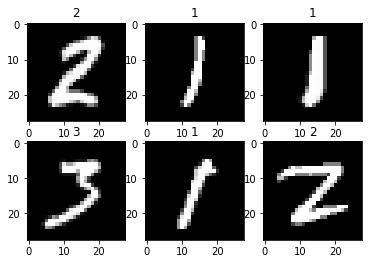

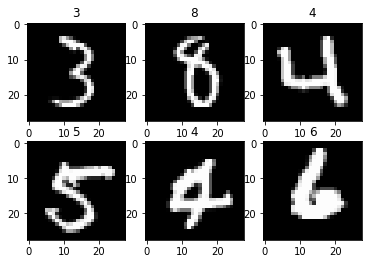

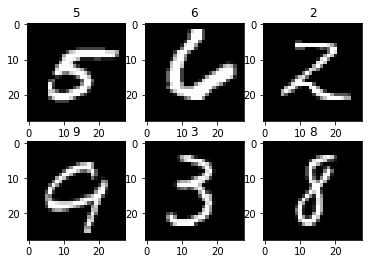

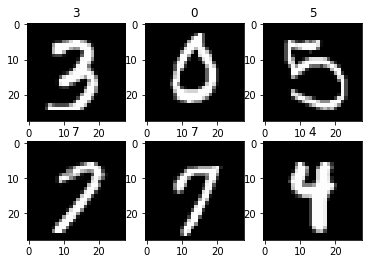

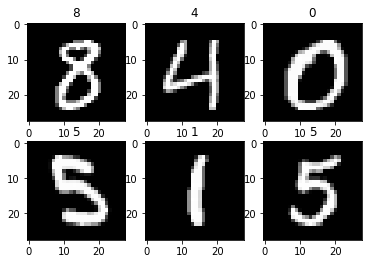

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
data_path = 'train.tfrecords'  # address to save the hdf5 file

with tf.Session() as sess:
    feature = {'train/image': tf.FixedLenFeature([], tf.string),
               'train/label': tf.FixedLenFeature([], tf.int64)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['train/image'], tf.float32)

    # Cast label data into int32
    label = tf.cast(features['train/label'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [28, 28, 3])

    # Any preprocessing here ...

    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)

    # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for batch_index in range(5):
        img, lbl = sess.run([images, labels])
        img = img.astype(np.uint8)
        for j in range(6):
            plt.subplot(2, 3, j + 1)
            plt.imshow(img[j, ...])
            plt.title(lbl[j])
        plt.show()
    # Stop the threads
    coord.request_stop()

    # Wait for threads to stop
    coord.join(threads)
    sess.close()